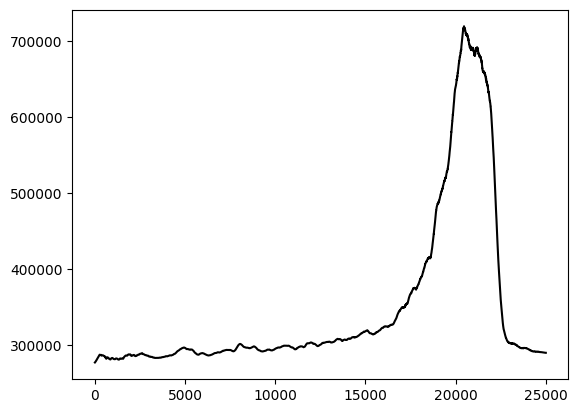

In [38]:
%matplotlib inline
import numpy as np
import warnings
import matplotlib.pyplot as plt
import scipy.signal as sig
import os
from numpy.fft import rfft, irfft 
import re
import sys, os

warnings.filterwarnings("ignore")
# Add the directory containing the package to sys.path
package_dir = os.path.abspath("C:/Users/froll/Documents/Labo/Projets/Violon/scripts")
if package_dir not in sys.path:
    sys.path.insert(0, package_dir)
import Tools3D as tools3d

package_dir = os.path.abspath("C:/Users/froll/Documents/Labo/Projets/RayoVox")
if package_dir not in sys.path:
    sys.path.insert(0, package_dir)

#Vitesse du son au moment de la mesure, dependant de la temperature:
Tc = 21.5 
C = np.sqrt( 1.4 * 287 *(Tc + 273) )
Path = './'
DatFiles = [f for f in os.listdir('../data/raw/Marteau') if f.endswith('.dat')]
DatFiles = [DatFiles[i] for i in [0,3,4,5,1,2]]
NbMems = 256
NbVoies = 260
Fe = 50000
WinLen = 10000
iDly = 5
NbPings = 5
NbViol = 6
Dyn = 30
SMemsPaPerDigit = 3.54e-6 # Pa/digit
SMicRefVPerPa= 1e-3 # V/Pa
SHammerVPerN = 22.5e-3# V/N
SAnalogVPerDigit = 0.332e-6# V/digit
FRFMems1 = np.load('../results/FRFMemsHOSMAAvg.npz')['FRF']
fMems1 = np.load('../results/FRFMemsHOSMAAvg.npz')['f']
FRFMems1 += 1 - FRFMems1[np.argmin(np.abs(fMems1-1000))]
FRFMems1 /= SMemsPaPerDigit

#_=plt.plot(fMems1,20*np.log10(FRFMems1),'k')
_=plt.plot(fMems1,FRFMems1,'k')
# plt.xlim(100,10000)
# plt.ylim(-10,10)



## Arrangement des 5 coups de marteau en 5 observations

(0.0, 20.0)

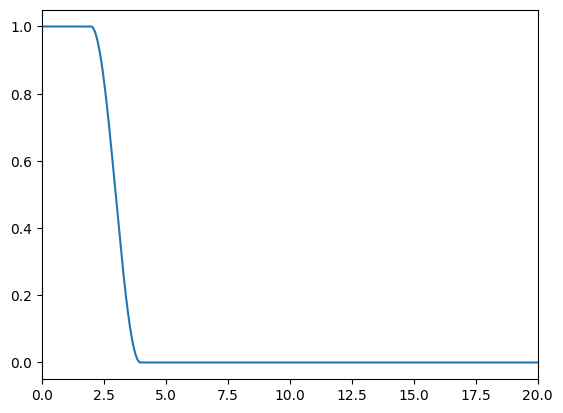

In [39]:
tW = np.arange(WinLen)/Fe
tWMax = 0.02
#RectTuckeyWindow for the hammer signal
lenWHmr = 200
RectTukeyWin = sig.windows.tukey(2*lenWHmr, alpha=0.5)
RectTukeyWin = RectTukeyWin[lenWHmr:]
RectTukeyWin = np.hstack((RectTukeyWin, np.zeros(WinLen-lenWHmr)))
plt.plot(1000*tW, RectTukeyWin)
plt.xlim(0, 1000*tWMax)

In [40]:
from scipy.signal import butter, filtfilt
from tqdm import tqdm
Thrshld = 0.5
# Design a Butterworth filter
cutoffL = 100  # Cutoff frequency in Hz
cutoffH = 10000  # Cutoff frequency in Hz

order = 6  # Filter order
b, a = butter(order, np.array([cutoffL, cutoffH]) / (0.5 * Fe), btype='Bandpass')

FramesHmr = []
FramesMcr = []
FramesMms = []

nv = -1 
NumViolon = []  
print(DatFiles)
for f in tqdm(DatFiles):
    NumViolon.append(int(re.findall(r'\d+', f)[0]))
    nv += 1
    with open('../data/raw/Marteau/' + f) as DatFile : 
        data = np.fromfile(DatFile, dtype='int32').reshape((-1, NbVoies))
        compteur = data[:,0]
        Mems = data[:, 1:NbMems+1].astype('float')
        
        # Compensate for average Mems FRF
        # Rmq : Les DatFiles n'ont pas tous la même longueur, donc on interpole le FRF pour chaque fichier
        Freqs = np.fft.rfftfreq(Mems.shape[0], 1/Fe)
        FRFInt = np.interp(Freqs, fMems1, np.real(FRFMems1)) + 1j * np.interp(Freqs, fMems1, np.imag(FRFMems1))
        Mems = np.fft.irfft(np.fft.rfft(Mems, axis=0) / FRFInt[:,None], axis=0)
        
        Refs = data[:, NbMems+1:].astype('float')*SAnalogVPerDigit
        NbEch = data.shape[0]
        t = np.arange(NbEch)/Fe
    Hammer = Refs[:,2]/SHammerVPerN # Newton
    # Filtrage passe-bande [100, 10k] Hz
    Hammer = filtfilt(b,a,Hammer)
    Micref = Refs[:,1]/SMicRefVPerPa
    Micref = filtfilt(b,a,Micref)    
    Mems = filtfilt(b, a, Mems, axis = 0)
       
    for i in range(NbPings):
        Ham = Hammer/np.max(np.abs(Hammer))
        for j in range(len(Hammer)):
            if Ham[j] > Thrshld:
                iTrig = j - iDly
                j += WinLen - iDly
                Hmr = Hammer[iTrig:iTrig+WinLen] * RectTukeyWin            
                Mcr = Micref[iTrig:iTrig+WinLen]
                Mms = Mems[iTrig:iTrig+WinLen, :]  
                Hmr[200:] = 0
                inegs = np.where(Hmr[:200] < 0)
                Hmr[:200] -= np.mean(Hmr[inegs]) 
                HmrN = Hmr/np.max(np.abs(Hmr))
                McrN = Mcr/np.max(np.abs(Mcr))
                MmsN = Mms/np.max(np.abs(Mms), axis=0)[None,:]
                
                FramesHmr.append(Hmr)
                FramesMcr.append(Mcr)
                FramesMms.append(Mms)
                break     
        Hammer = Hammer[j:]
        Micref = Micref[j:] 
        Mems = Mems[j:,:]    
    
# Reshape the arrays as requested
FramesHmr = np.array(FramesHmr).reshape((NbViol, NbPings, WinLen, 1))
FramesMcr = np.array(FramesMcr).reshape((NbViol, NbPings, WinLen, 1))
FramesMms = np.array(FramesMms).reshape((NbViol, NbPings, WinLen, NbMems))

['hammer1.dat', 'hammer4.dat', 'hammer5.dat', 'hammer9.dat', 'hammer11.dat', 'hammer13.dat']


100%|██████████| 6/6 [02:11<00:00, 21.85s/it]


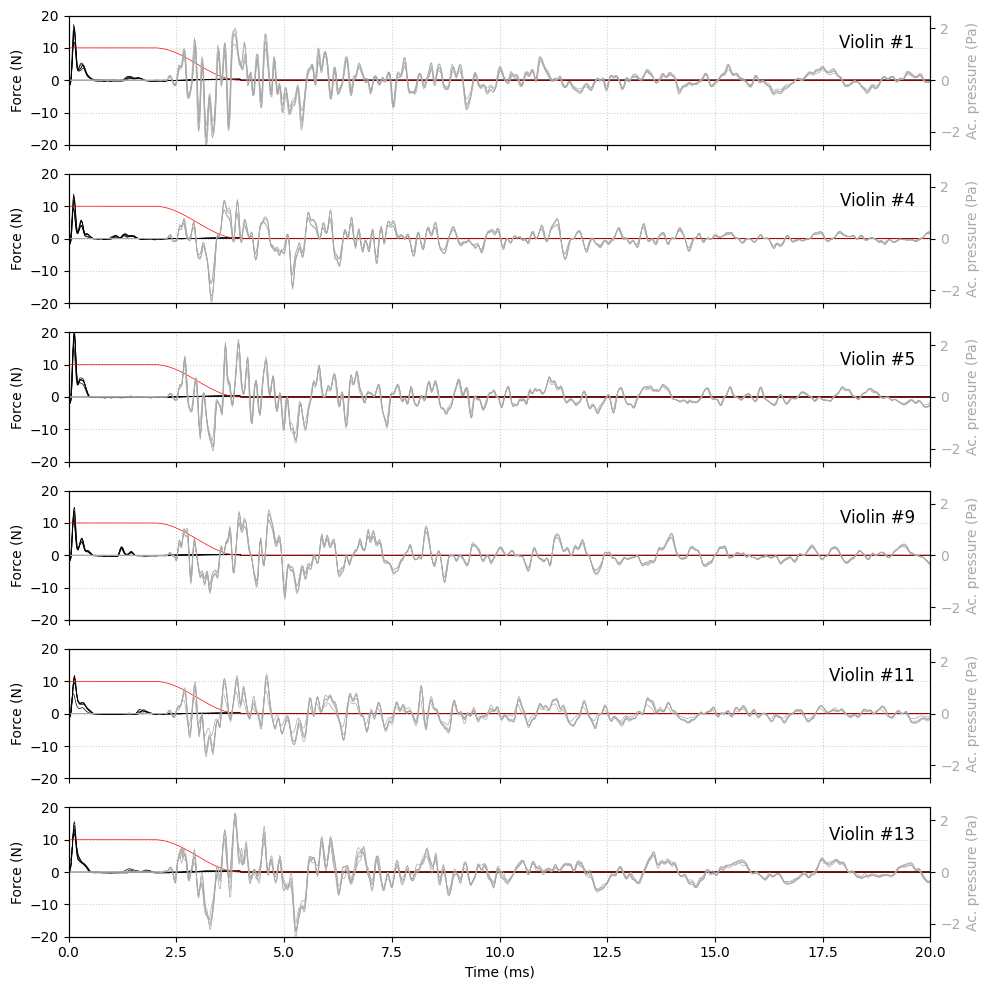

In [41]:

fig,ax = plt.subplots(NbViol,1,figsize=(10,10)) 
for nv in range(NbViol):
    # Create secondary axis for envelopes
    ax2 = ax[nv].twinx()
    ax[nv].plot(1000*tW,FramesHmr[nv, :, :, 0].T,'k', lw = 0.5)
    ax[nv].plot(1000*tW,10*RectTukeyWin,'r', lw = 0.5)
    ax2.plot(1000*tW, FramesMms[nv, :, :, 0].T,'darkgrey', lw = 0.5)
    ax[nv].set_xlim([0, 1000*tWMax])
    ax[nv].text(1000*tWMax, 10, f'Violin #{NumViolon[nv]:d}   ', fontsize=12, ha='right')
    ax[nv].set_ylim([-20, 20])
    ax[nv].set_ylabel('Force (N)')
    ax2.set_ylim([-2.5, 2.5])
    ax2.set_ylabel('Ac. pressure (Pa)', color='darkgrey')

    # Add grid
    ax[nv].grid(True, linestyle=':', alpha=0.6)

    # Remove tick labels
    if nv < NbViol - 1:
        ax[nv].set_xticklabels([])
    else:    
        ax[nv].set_xlabel('Time (ms)')
        
    # Keep axis and ticks
    ax[nv].xaxis.set_ticks_position('bottom')
    ax[nv].yaxis.set_ticks_position('left')
    ax2.yaxis.set_ticks_position('right')
    
    # Set colors for clarity
    ax2.tick_params(axis='y', labelcolor='darkgrey')
fig.tight_layout()


# Systeme Linéaire Marteau-Micro de l'antenne
## Calcul des cohérences, fonctions de transfert et RIs

In [42]:
# DSPs
Shh = np.mean(np.abs(rfft(FramesHmr, axis=2))**2, axis=1)
Srr = np.mean(np.abs(rfft(FramesMcr, axis=2))**2, axis=1)
Smm = np.mean(np.abs(rfft(FramesMms, axis=2))**2, axis=1)
# CSPs
Shr = np.mean(np.conj( rfft(FramesHmr, axis=2)) * (rfft(FramesMcr, axis=2)), axis=1)
Shm = np.mean(np.conj( rfft(FramesHmr, axis=2)) * (rfft(FramesMms, axis=2)), axis=1)
Srm = np.mean(np.conj( rfft(FramesMcr, axis=2)) * (rfft(FramesMms, axis=2)), axis=1)
# Cohérences
Cohr = np.abs(Shr)**2 / (Shh * Srr)
Cohm = np.abs(Shm)**2 / (Shh * Smm)
Corm = np.abs(Srm)**2 / (Srr * Smm)
# FRFs
Hhr = Shr / Shh 
Hhm = Shm / Shh
Hrm = Srm / Srr
# RIs
RIhr = irfft(Hhr, axis=1)
RIhm = irfft(Hhm, axis=1)
RIrm = irfft(Hrm, axis=1)

frq = np.fft.rfftfreq(WinLen, 1/Fe)
np.savez('./../results/ViolinsFRFsAndRIs.npz', frq=frq, Shh=Shh, Srr=Srr, Smm=Smm, Shr=Shr, Shm=Shm, Srm=Srm, Cohr=Cohr, Cohm=Cohm, Corm=Corm, Hhr=Hhr, Hhm=Hhm, Hrm=Hrm, RIhr=RIhr, RIhm=RIhm, RIrm=RIrm)


Max Level of Hhm detected for Violin #9 at 1540.0 Hz on Mems #243


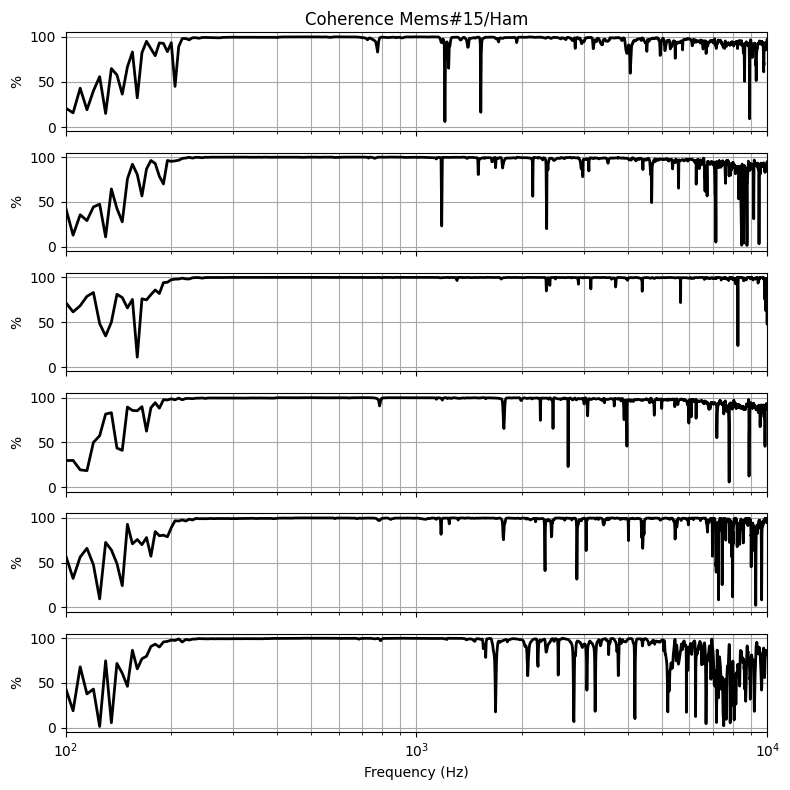

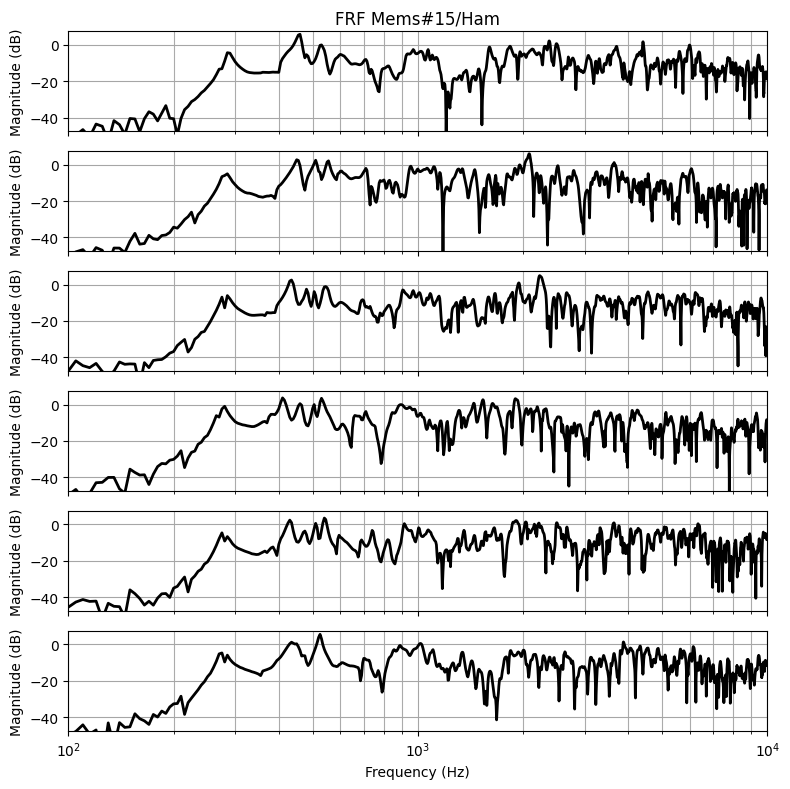

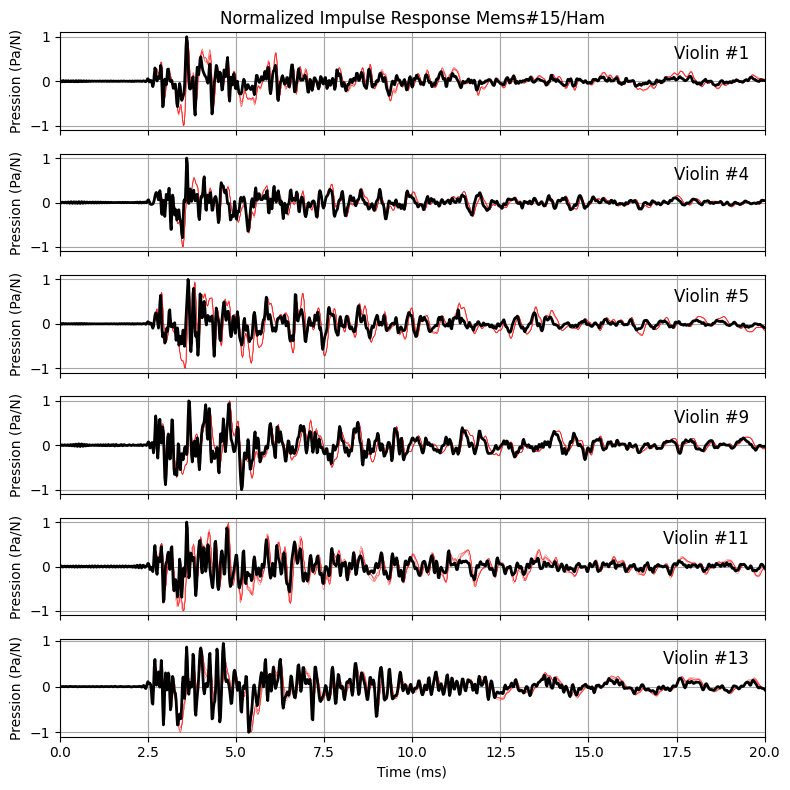

In [43]:
frqMax = 10000
tWMax = 0.02
Dyn = 50
# Find the indices of the maximum value in Hhm (Global Max)
iViol, iFreq, nm_maxLvl = np.unravel_index(np.argmax(np.abs(Hhm)), Hhm.shape)
print(f"Max Level of Hhm detected for Violin #{NumViolon[iViol]} at {frq[iFreq]:.1f} Hz on Mems #{nm_maxLvl}")
nm_1m = 15
Cohmin = np.min(Cohm[:,:,::16],axis=2)
Cohmax = np.max(Cohm[:,:,::16],axis=2)
CohAvg = np.mean(Cohm[:,:,::16],axis=2)

FRFmin = np.min(np.abs(Hhm[:,:,::25]),axis=2)
FRFmax = np.max(np.abs(Hhm[:,:,::25]),axis=2)
FRFAvg = np.mean(np.abs(Hhm[:,:,::25]),axis=2)

fig31, ax31 = plt.subplots(6,1,figsize=(8,8))
fig32, ax32 = plt.subplots(6,1,figsize=(8,8))
fig33, ax33 = plt.subplots(6,1,figsize=(8,8))

VGlobalMax = np.abs(Hhm[iViol, iFreq, nm_1m])
VGlobalMaxdB = 20*np.log10(VGlobalMax)

for nv in range(NbViol):
    #Cohérence
    ax31[nv].plot(frq, 100*Cohm[nv,:,nm_1m], 'k', lw = 2)
    ax31[nv].set_xscale('log')
    ax31[nv].set_xlim([100, frqMax])
    ax31[nv].set_ylabel('%')
    ax31[nv].xaxis.set_ticks_position('bottom')
    ax31[nv].yaxis.set_ticks_position('left')
    ax31[nv].grid(True, which="major", ls="-", color='0.65')
    ax31[nv].grid(True, which="minor", ls="-", color='0.35', alpha=0.5)    

    # Remove tick labels
    if nv < 5:
        ax31[nv].set_xticklabels([])
    else:    
        ax31[nv].set_xlabel('Frequency (Hz)')
    if not nv : 
        ax31[nv].set_title(f'Coherence Mems#{nm_1m}/Ham')
    #FRF Amplitude
    ax32[nv].plot(frq, 20*np.log10(np.abs(Hhm[nv,:,nm_1m])), 'k', lw = 2, zorder = 2)
    ax32[nv].set_xscale('log')
    ax32[nv].set_xlim([100, frqMax])
    ax32[nv].set_ylim([VGlobalMaxdB-Dyn, VGlobalMaxdB+5])
    ax32[nv].set_ylabel('Magnitude (dB)')
    ax32[nv].xaxis.set_ticks_position('bottom')
    ax32[nv].yaxis.set_ticks_position('left')
    ax32[nv].grid(True, which="major", ls="-", color='0.65')
    ax32[nv].grid(True, which="minor", ls="-", color='0.35', alpha=0.5)    

    #FRF Phase
    # ax3b = ax32[nv].twinx()
    # ax3b.plot(frq, np.unwrap(np.angle(Hhm[nv,:,nm_1m])),'r', '-', lw = 2, zorder = 1 )  
    # ax3b.set_ylabel('radians')
    # ax3b.xaxis.set_ticks_position('bottom')
    # ax3b.yaxis.set_ticks_position('right')
    if nv < 5:
        ax32[nv].set_xticklabels([])
    else:    
        ax32[nv].set_xlabel('Frequency (Hz)')
    if not nv : 
        ax32[nv].set_title(f'FRF Mems#{nm_1m}/Ham')
    
    Gain = 1/np.max(np.abs(RIhm),axis = 1)[:,None,:]
    FramesMmsN = FramesMms/np.max(np.abs(FramesMms), axis=2)[:,:,None]
    RIhmN = RIhm*Gain
    Gain /= np.max(np.abs(Gain), axis=0) # Normalize Gain
    
    ax33[nv].plot(1000*(tW-iDly/Fe), FramesMmsN[nv,:,:,nm_1m].T, 'r', lw = 0.2)
    ax33[nv].plot(1000*tW, RIhmN[nv, :, nm_1m], 'k', lw = 2)    
    
    ax33[nv].set_xlim([0, 1000*tWMax])
    ax33[nv].set_ylabel('Pression (Pa/N)')
    ax33[nv].text(1000*tWMax, 0.5, f'Violin #{NumViolon[nv]:d}   ', fontsize=12, ha='right')
    ax33[nv].grid(True, which="major", ls="-", color='0.65')
    ax33[nv].grid(True, which="minor", ls="-", color='0.35', alpha=0.5)    

    ax33[nv].xaxis.set_ticks_position('bottom')
    ax33[nv].yaxis.set_ticks_position('left')
    # Remove tick labels
    if nv < 5:
        ax33[nv].set_xticklabels([])
    else:    
        ax33[nv].set_xlabel('Time (ms)')
    if not nv : 
        ax33[nv].set_title(f'Normalized Impulse Response Mems#{nm_1m}/Ham')
fig31.tight_layout()
fig32.tight_layout()
fig33.tight_layout()
